This script is for analysing the CRPS performance of ensemble forecasts before and after post-processings. Please refer to Section 3.3.2 of the report for more information on the CRPS. This script produces Figure 4.10 in the report.

In [10]:
import CRPS.CRPS as pscore
import numpy as np
import xarray as xr
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import time
import pickle 

In [2]:
# Change paths for own use
ROOT = "ROOT/"
data_path = ROOT+"raw_data_EUPPBench/"
result_path = ROOT+"trained_models/lead_time_continuous/"

In [3]:
# Loading the data in netCDF format
vis_forecast_obs = xr.open_dataarray(data_path + "vis_forecast_observations.nc")
vis_forecast = xr.open_dataarray(data_path + "vis_forecasts.nc")

/Users/clifflau/opt/anaconda3/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [4]:
# Create arrays for latitude, longitudes, base times, lead times and orecasted/observed values
lat = np.array(vis_forecast_obs['latitude'])
lon = np.array(vis_forecast_obs['longitude'])
alt = np.array(vis_forecast_obs['altitude'])
base= np.array(vis_forecast_obs['forecast_reference_time'])[365:]
lead = np.array(vis_forecast_obs['forecast_period'][1:]) # consider lead times from 6 to 120 hrs
lead_hr = np.array(lead*10**-9/3600, dtype='int')
vis_forecast_obs_array = np.array(vis_forecast_obs[1:, 0:118, 365:])
vis_forecast_array = np.array(vis_forecast[1:, :, 0:118, 365:]) # consider first 119 stations only

In [28]:
st = time.time()
crps_lead = []
for l in range(len(lead)):
    crps = []
    for s in range(len(lon)):
        for b in range(len(base)):
            if vis_reforecast_obs_array[l,s,b]>100000:
                continue
            crps.append(pscore(vis_reforecast_array[l,:,s,b], vis_reforecast_obs_array[l,s,b]).compute()[0])
    crps_lead.append(np.mean(crps))

et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Execution time: 125.60266399383545 seconds


# Modelling raw visibility observations

In [6]:
# Results df (calibrated forecasts by quantile regression forest)
df_test_result = pd.read_csv(result_path + "results_giant_20_300_quantile.csv")

In [31]:
# Compute CRPS for different lead times
crps_calibrated_lead = []
crps_baseline_lead = []
for l in np.arange(6,121,6):
    crps_calibrated = []
    crps_baseline = []
    df_test_result_lead = df_test_result[df_test_result['lead_hr']==l]
    df_test_result_lead = df_test_result_lead.iloc[:,4:]
    for i in range(len(df_test_result_lead)):
        crps_calibrated.append(pscore(df_test_result_lead.iloc[[i]].values[0][1:52] , df_test_result_lead.iloc[[i]].values[0][0]).compute()[0])
        crps_baseline.append(pscore(df_test_result_lead.iloc[[i]].values[0][52:] , df_test_result_lead.iloc[[i]].values[0][0]).compute()[0])
    crps_calibrated_lead.append(np.mean(crps_calibrated))
    crps_baseline_lead.append(np.mean(crps_baseline))

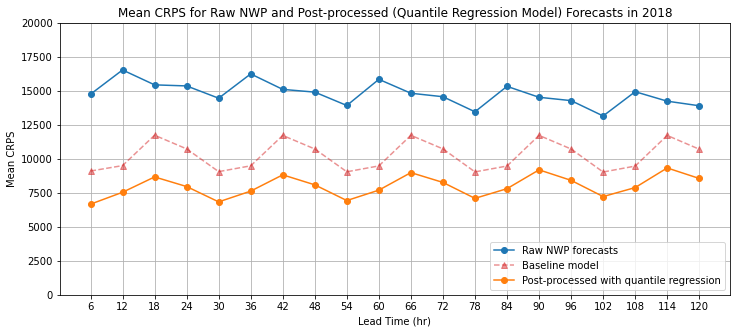

In [35]:
plt.figure(figsize=(12,5))
plt.plot(lead_hr, crps_lead, 'o-', label='Raw NWP forecasts')
plt.plot(lead_hr, crps_baseline_lead, '^--', label='Baseline model', color='tab:red', alpha=0.5)
plt.plot(lead_hr, crps_calibrated_lead, 'o-', label='Post-processed with quantile regression')
plt.ylim(0,20000)
plt.grid()
plt.xticks(lead_hr)
plt.xlabel("Lead Time (hr)")
plt.ylabel("Mean CRPS")
plt.title("Mean CRPS for Raw NWP and Post-processed (Quantile Regression Model) Forecasts in 2018")
plt.legend(loc='lower right')

# Modelling transformed visibility observations

In [36]:
# Results df (calibrated forecasts by quantile regression forest modelling log-transformed vis obs)
df_test_result = pd.read_csv(result_path + "results_giant_20_300_quantile_log.csv")

In [38]:
# Compute CRPS for different lead times
crps_calibrated_log_lead = []
for l in np.arange(6,121,6):
    crps_calibrated_log = []
    df_test_result_lead = df_test_result[df_test_result['lead_hr']==l]
    df_test_result_lead = df_test_result_lead.iloc[:,4:]
    for i in range(len(df_test_result_lead)):
        crps_calibrated_log.append(pscore(df_test_result_lead.iloc[[i]].values[0][1:52] , df_test_result_lead.iloc[[i]].values[0][0]).compute()[0])
    crps_calibrated_log_lead.append(np.mean(crps_calibrated_log))

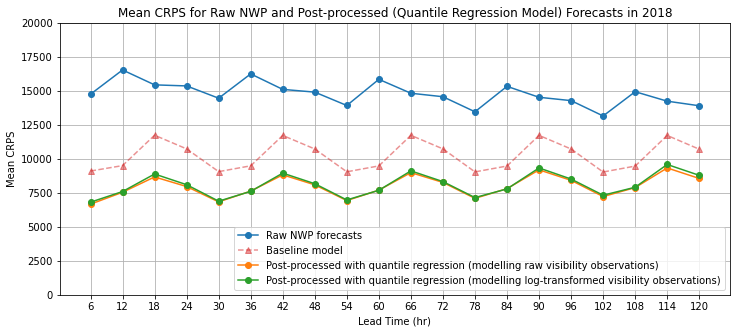

In [45]:
plt.figure(figsize=(12,5))
plt.plot(lead_hr, crps_lead, 'o-', label='Raw NWP forecasts')
plt.plot(lead_hr, crps_baseline_lead, '^--', label='Baseline model', color='tab:red', alpha=0.5)
plt.plot(lead_hr, crps_calibrated_lead, 'o-', label='Post-processed with quantile regression (modelling raw visibility observations)')
plt.plot(lead_hr, crps_calibrated_log_lead, 'o-', label='Post-processed with quantile regression (modelling log-transformed visibility observations)')
plt.ylim(0,20000)
plt.grid()
plt.xticks(lead_hr)
plt.xlabel("Lead Time (hr)")
plt.ylabel("Mean CRPS")
plt.title("Mean CRPS for Raw NWP and Post-processed (Quantile Regression Model) Forecasts in 2018")
plt.legend(loc='lower right')